In [16]:
import stompy.model.delft.dflow_model as dfm
import numpy as np
import logging
import pandas as pd
import xarray as xr
from stompy.grid import multi_ugrid
from stompy import utils
import os
import six
import matplotlib.pyplot as plt
from matplotlib import colors

%matplotlib notebook

In [17]:
fig_dir="fig-scenarios-20220902"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [18]:
def mod_str(self):
    return f'<DFlowModel: {self.run_dir}>'
dfm.DFlowModel.__repr__ = mod_str
dfm.DFlowModel.__str__ = mod_str

In [19]:
import run_database
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
def load_or_none(rd):
    try:
        return dfm.DFlowModel.load(rd)
    except FileNotFoundError:
        return None
    
scen_names={0:'Base',1:'Low',2:'Medium',3:'High'}

In [20]:
events=[(np.datetime64('2016-08-11'),' Closure'),
        (np.datetime64('2016-11-01'),' Sm. Breach'),
        (np.datetime64('2016-12-11'),' Lg. Breach'),
        (np.datetime64('2017-02-07'),' Peak\n Flow'),
       ]
def label_events(ax):
    # Label events
    trans=ax.get_xaxis_transform()
    for t,name in events:
        ax.text(t,0.01,name,transform=ax.get_xaxis_transform(),va='bottom',clip_on=1)
        ax.plot([t,t],[0.,0.03],transform=trans,color='k',lw=0.75)

In [52]:
import common
six.moves.reload_module(common)
from common import prechain, his_cache

In [45]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
runs=all_runs[ 
    (all_runs.layers==100) 
    & (all_runs.period=='2016long')
    & (all_runs.flows=='impaired')
    & (all_runs.slr==0.0)
].copy()
runs['name']=runs.scen.map(scen_names)

six.moves.reload_module(dfm)
runs['model']=runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
runs

run_dir  scen  layers  slr  \
0  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.0   
1  data_2016long_3d_asbuilt_impaired_scen1_l100-v...     1     100  0.0   
2  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100  0.0   
3  data_2016long_3d_asbuilt_impaired_scen3_l100-v...     3     100  0.0   

     period    status     flows    name  \
0  2016long  complete  impaired    Base   
1  2016long  complete  impaired     Low   
2  2016long  complete  impaired  Medium   
3  2016long  complete  impaired    High   

                                               model  
0  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
1  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
2  <DFlowModel: data_2016long_3d_asbuilt_impaired...  
3  <DFlowModel: data_2016long_3d_asbuilt_impaired...

Stage
---

Preliminary 2D plots:

First step is to verify that the scenarios are working as planned.
 - time series of waterlevel at key locations
 
Second step is to go through the analyses in the scope:
 - which can be handled in 2D
 - do any require more output than is currently configured?
 


In [46]:
stage_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['npc','Ped. Bridge'],
                 ['nmp','North Marsh Panne'],
               ]

In [47]:
def fig_waterlevel_discharge_bystation_timeseries(runs,station,label):
    fig,axs=plt.subplots(2,1,figsize=(7.5,4),sharex=True)

    # Stage at stations:
    colors={}
    ax=axs[0]
    
    for _,rec in runs.iterrows():
        his=rec['model'].his_dataset(chain=True,prechain=prechain) # use preloaded
    
        l=ax.plot(his.time,
                  his.waterlevel.sel(stations=station),
                  label=rec['name'],
                  lw=1.5,alpha=0.6)
        colors[rec['name']]=l[0].get_color()

    if 1: # show mouth thalweg, too
        for _,rec in runs.iterrows():
            his=rec['model'].his_dataset() # use preloaded
            ax.plot(his.time,
                    his.general_structure_crest_level.sel(general_structures='mouth'),
                    label='__nolabel__',
                    ls='--',color=colors[rec['name']],
                    lw=1.5,alpha=0.6)
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')

    ax=axs[1]
    for _,rec in runs.iterrows():
        his=rec['model'].his_dataset(chain=True,prechain=prechain)
        if 'pch_gate' in his.general_structures:
            ax.plot(his.time,
                    his.general_structure_discharge.sel(general_structures='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'gategens' in his.dims and 'pch_gate' in his.gategens:
            ax.plot(his.time,
                    his.gategen_discharge.sel(gategens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)
        elif 'pch_gate' in his.weirgens:
            ax.plot(his.time,
                    his.weirgen_discharge.sel(weirgens='pch_gate'),
                    label=rec['name'],
                    lw=1.5,alpha=0.6)                
        
    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    ax.set_ylabel('Flow (m3/s)')
    
    fig.subplots_adjust(right=0.80,left=0.1,top=0.98)
    fig.autofmt_xdate()
    return fig

<IPython.core.display.Javascript object>


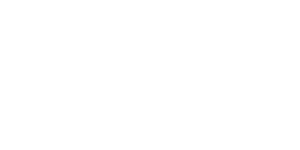

<IPython.core.display.Javascript object>


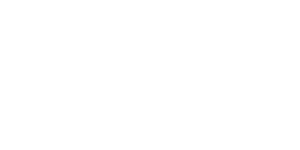

<IPython.core.display.Javascript object>


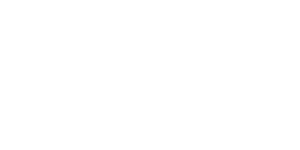

<IPython.core.display.Javascript object>


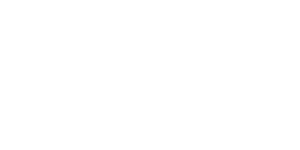

<IPython.core.display.Javascript object>


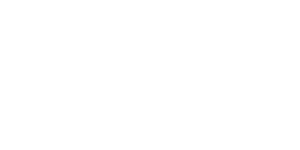

In [9]:
for station,label in stage_stations:
    fig=fig_waterlevel_discharge_bystation_timeseries(runs,station,label)
    fig.savefig(os.path.join(fig_dir,f'stage_Q-timeseries-2016-stn_{station}.png'),
                dpi=150)

In [ ]:
# Similar plots, but each panel is one station.
def fig_waterlevel_bystation_timeseries(runs,station,label,as_depth=False,chain=True):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    datas=[] # double plural
    
    for _,rec in runs.iterrows():
        his_wse = his_cache(rec['model'],stations=station,
                            variable='waterlevel',chain=chain)
        if rec['name']=='Base':
            zorder=3 # smaller tidal range, so plot on top.
        else:
            zorder=2
            
        data=his_wse
        if as_depth:
            z_bed=his_cache(rec['model'],stations=station,variable='bedlevel',
                            chain=chain)
            data=his_wse-z_bed
        ax.plot(data.time, data,
                label=rec['name'],
                lw=1.2,alpha=1,zorder=zorder)
        datas.append(data)

    ax.legend(loc='upper center',bbox_to_anchor=[0.45,1.12],ncol=len(runs),
              frameon=0)
    label_events(ax)

    t_min=min([data.time.values[0] for data in datas])
    t_max=max([data.time.values[-1] for data in datas])
    ax.axis(xmin=t_min,xmax=t_max)
    #data.time.values[0],xmax=data.time.values[-1])

    if as_depth:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_ylabel('Stage (m)')
        
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98,left=0.1,top=0.92, bottom=0.14)
    return fig

<IPython.core.display.Javascript object>


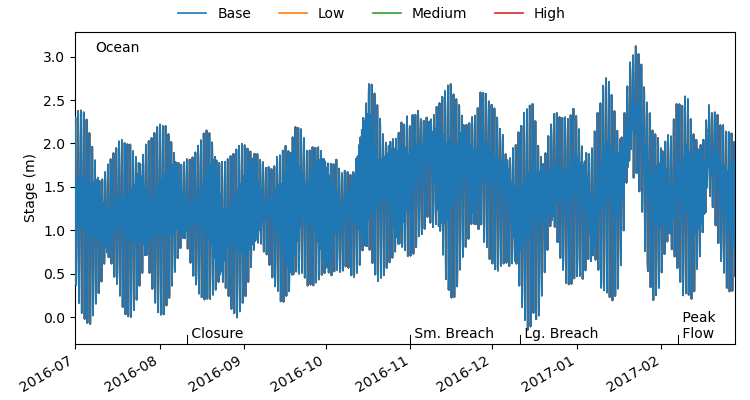

<IPython.core.display.Javascript object>


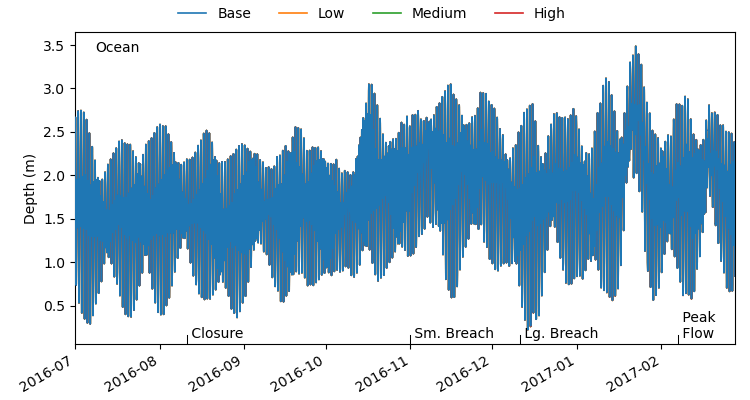

<IPython.core.display.Javascript object>


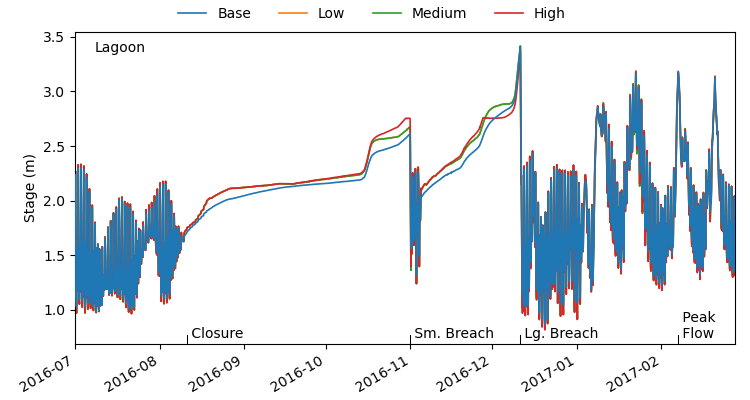

<IPython.core.display.Javascript object>


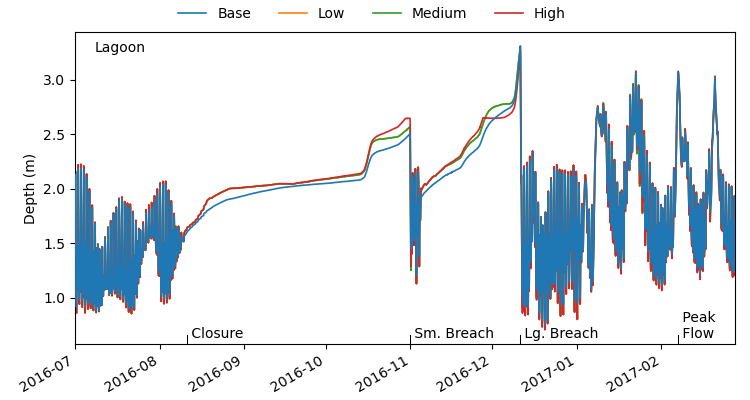

<IPython.core.display.Javascript object>


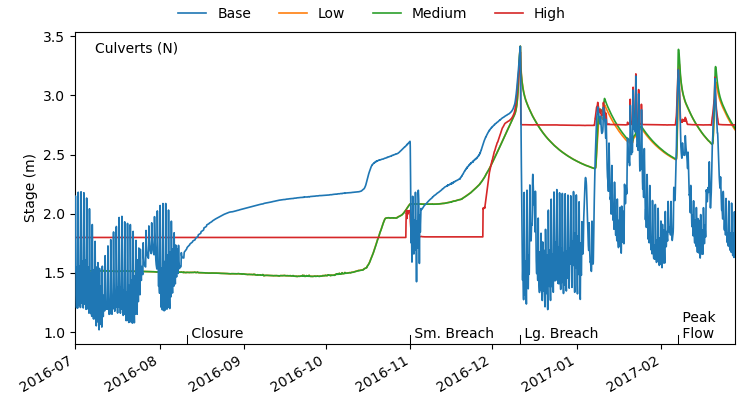

<IPython.core.display.Javascript object>


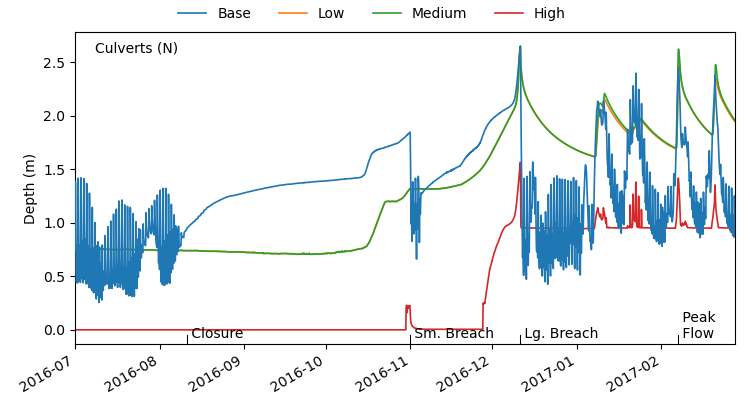

<IPython.core.display.Javascript object>


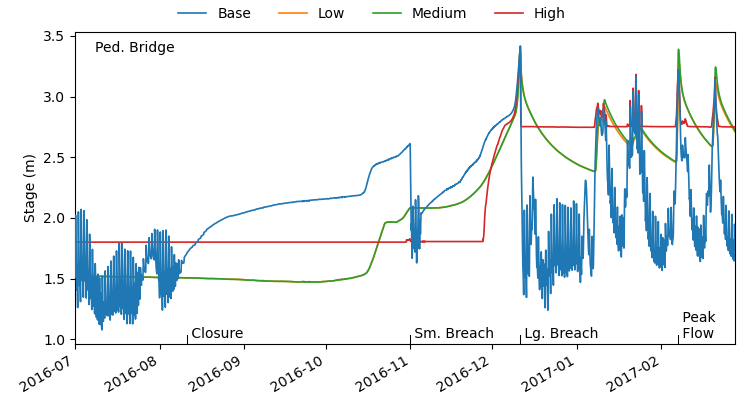

<IPython.core.display.Javascript object>


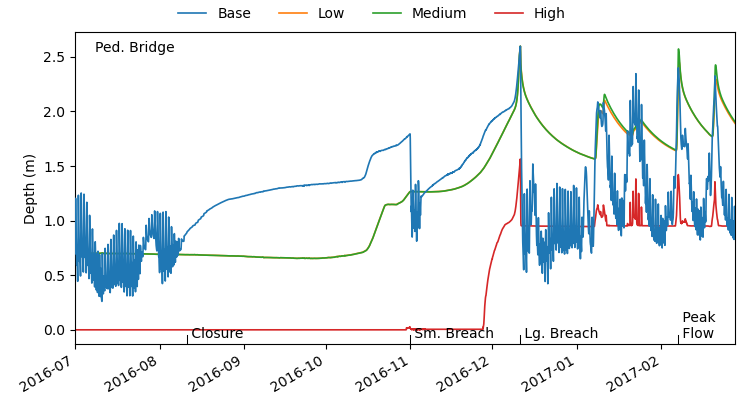

<IPython.core.display.Javascript object>


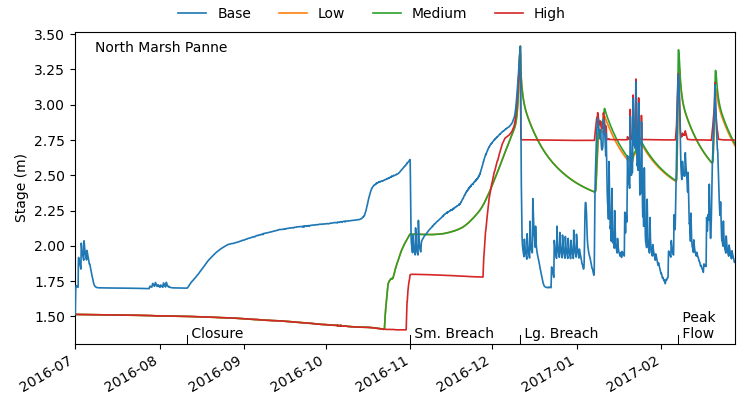

<IPython.core.display.Javascript object>


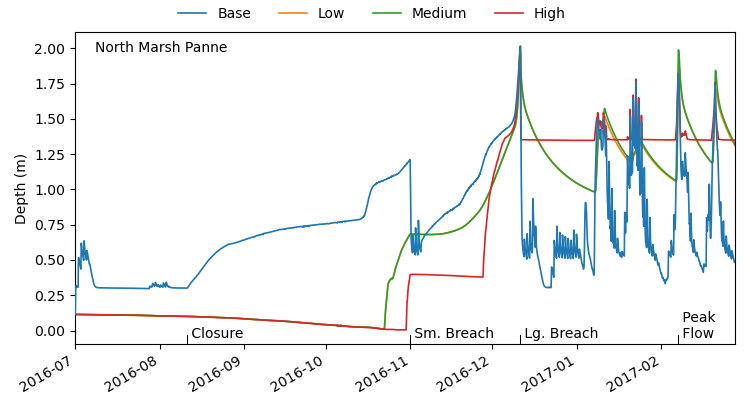

In [51]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(runs,station,label)
    fig.savefig(os.path.join(fig_dir,f'stage-timeseries-2016-stn_{station}.png'),
                dpi=150)
    fig2=fig_waterlevel_bystation_timeseries(runs,station,label,as_depth=True)
    fig2.savefig(os.path.join(fig_dir,f'depth-timeseries-2016-stn_{station}.png'),
                 dpi=150)

<IPython.core.display.Javascript object>


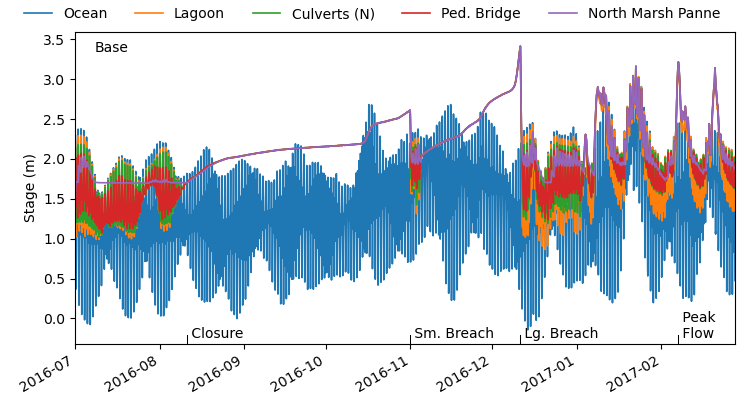

<IPython.core.display.Javascript object>


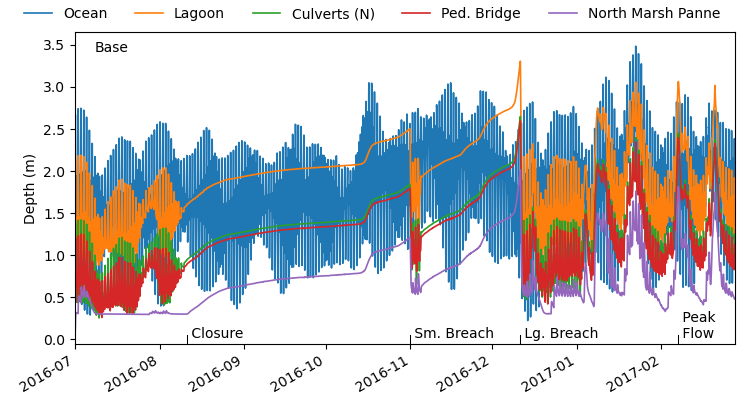

<IPython.core.display.Javascript object>


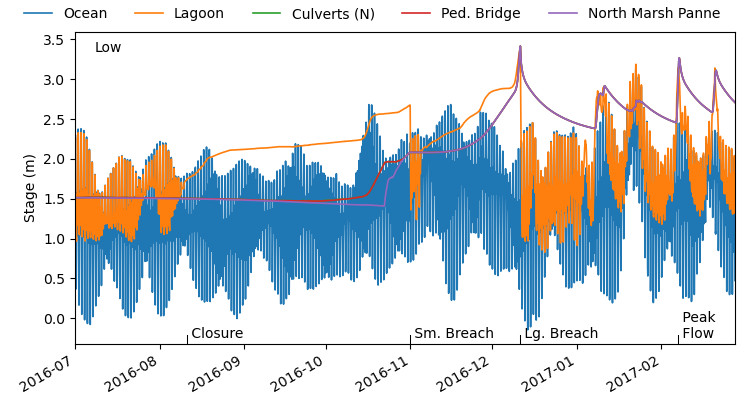

<IPython.core.display.Javascript object>


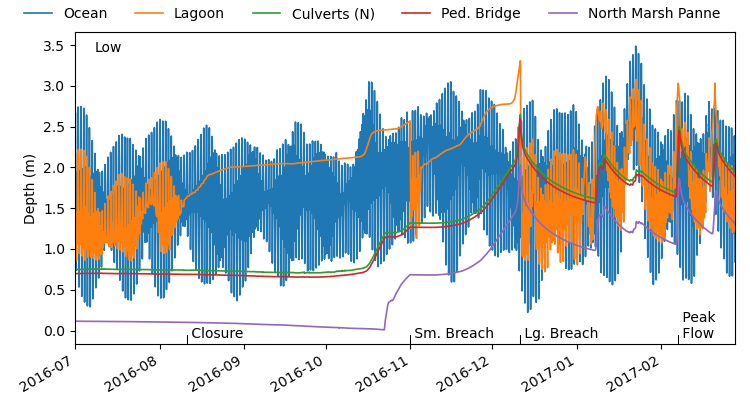

<IPython.core.display.Javascript object>


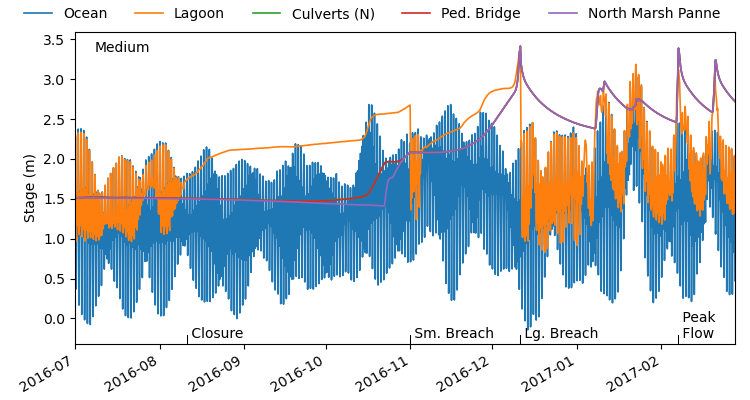

<IPython.core.display.Javascript object>


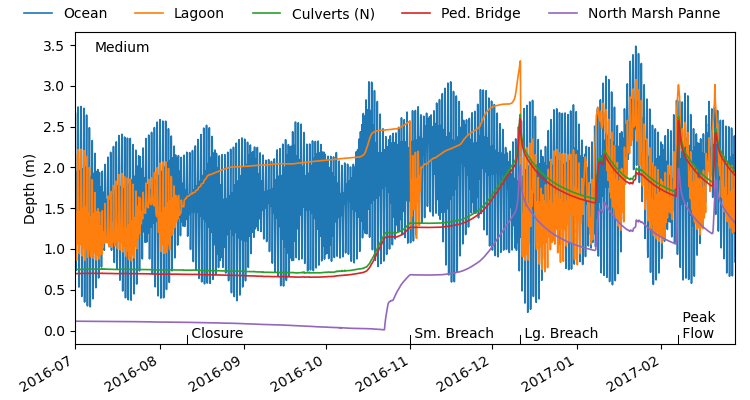

/home/rustyh/miniconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


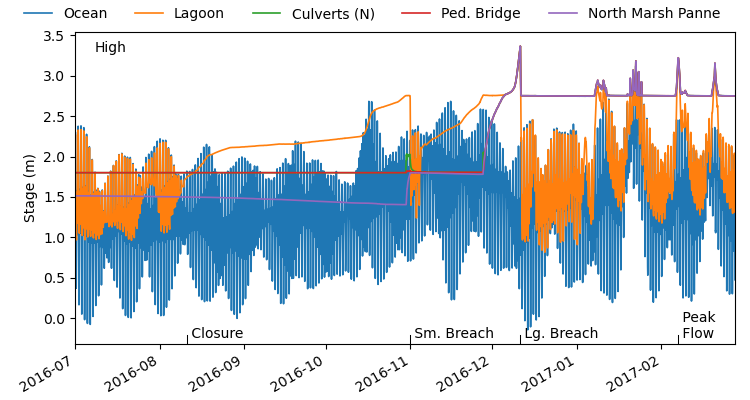

<IPython.core.display.Javascript object>


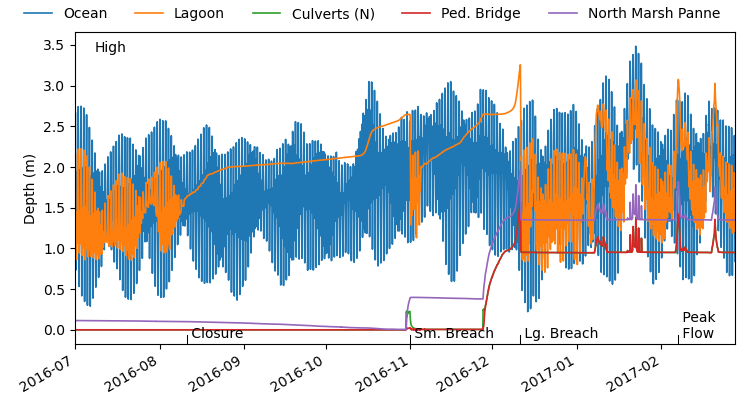

In [54]:
def fig_waterlevel_timeseries(rec, as_depth=False, chain=True):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    # will use pre-loaded his dataset, so let the caller choose whether
    # to chain or not.
    
    for station,name in stage_stations:
        data = his_cache(rec['model'],stations=station,variable='waterlevel',chain=chain)
        if as_depth:
            z_bed=his_cache(rec['model'],stations=station,variable='bedlevel',chain=chain)
            data=data-z_bed        
        ax.plot(data.time,data,lw=1.2,label=name)

    ax.legend(loc='upper center',bbox_to_anchor=[0.45,1.12],ncol=len(stage_stations),
              frameon=0)
    if as_depth:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,rec['name'],transform=ax.transAxes,ha='left',va='top')
        
    label_events(ax)
    
    ax.axis(xmin=data.time.values[0],xmax=data.time.values[-1])
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98,left=0.1,top=0.92, bottom=0.14)
    return fig

for _,rec in runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f"stage-timeseries-2016-{rec['name']}.png"),
                dpi=150)
    fig2=fig_waterlevel_timeseries(rec,as_depth=True) 
    fig2.savefig(os.path.join(fig_dir,f"depth-timeseries-2016-{rec['name']}.png"),
                 dpi=150)

In [55]:
plt.close('all')

Tidal Analysis
--

Bed stress

For bed stress, probably best to choose a day and re-run with half-hour output. Choose
2016-08-03 to 2016-08-05. Restarts are every 10 days, with one falling on 2016-08-04.

Tidal prism



In [13]:
# Start with 2D runs
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
if 1:
    tidal_runs=all_runs[ (all_runs.layers==100) & (all_runs.period=='2016tidal')
                        &(all_runs.slr==0.0)].copy()
    tidal_runs['name']=tidal_runs.scen.map({0:'Base',1:'Low',2:'Medium',3:'High'})
else:
    # some of these have a -v001, but does not include the tidal re-run
    tidal_runs=pd.DataFrame([
        dict(name='Base',run_dir='data_2016_2d_asbuilt_impaired/flowfmrtidal.mdu'),
        dict(name='Low', run_dir='data_2016_2d_asbuilt_impaired_scen1/flowfmrtidal.mdu'),
        dict(name='Medium',run_dir='data_2016_2d_asbuilt_impaired_scen2/flowfmrtidal.mdu'),
        dict(name='High',run_dir='data_2016_2d_asbuilt_impaired_scen3/flowfmrtidal.mdu')
    ])
tidal_runs

run_dir  scen  layers  slr  \
16  data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.0   
17  data_2016long_3d_asbuilt_impaired_scen1_l100-v...     1     100  0.0   
18  data_2016long_3d_asbuilt_impaired_scen2_l100-v...     2     100  0.0   
19  data_2016long_3d_asbuilt_impaired_scen3_l100-v...     3     100  0.0   

       period     status     flows    name  
16  2016tidal  completed  impaired    Base  
17  2016tidal  completed  impaired     Low  
18  2016tidal  completed  impaired  Medium  
19  2016tidal  completed  impaired    High

In [14]:
tidal_runs['model']=tidal_runs.run_dir.apply(load_or_none)

In [15]:
for station,label in stage_stations:
    fig_waterlevel_discharge_bystation_timeseries(tidal_runs,station,label)
    fig.savefig(os.path.join(fig_dir,f'tidal36h-stage_Q-timeseries-2016-stn{station}.png'),
                dpi=150)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
for station,label in stage_stations:
    fig=fig_waterlevel_bystation_timeseries(tidal_runs,station,label,chain=False)
    fig.savefig(os.path.join(fig_dir,f'tidal36h-stage-timeseries-2016-stn{station}.png'),
                dpi=150)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
for _,rec in tidal_runs.iterrows():
    fig=fig_waterlevel_timeseries(rec,chain=False) 
    fig.savefig(os.path.join(fig_dir,f"tidal36h-stage-timeseries-2016-{rec['name']}.png"),
                dpi=150)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
# Choose an ebb period and a flood period

# For the older runs:
#ebb_period=[np.datetime64('2016-08-04 06:30:00'),
#            np.datetime64('2016-08-04 13:30:00')]
#flood_period=[np.datetime64('2016-08-04 13:30:00'),
#              np.datetime64('2016-08-04 20:00:00')]

# For tidal runs based on 2016long:
ebb_period=[np.datetime64('2016-07-31 03:30:00'), # large ebb.
            np.datetime64('2016-07-31 11:00:00')]
flood_period=[np.datetime64('2016-07-31 11:00:00'),
              np.datetime64('2016-07-31 17:00:00')]


In [ ]:
ebb_sels=[]
flood_sels=[]
grid=None

for _,rec in tidal_runs.iterrows():
    ds=rec['model'].map_dataset(grid=grid)
    grid=grid or ds.grid # so everybody matches the same grid
    ebb_sels.append( (ebb_period[0]<=ds.time.values)&(ds.time.values<=ebb_period[1]) )
    flood_sels.append( (flood_period[0]<=ds.time.values)&(ds.time.values<=flood_period[1]) )

tidal_runs['ebb_sel']=ebb_sels
tidal_runs['flood_sel']=flood_sels

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removin

In [ ]:
# mean and max bed stress for each of the runs, for flood and ebb
# during dev, Fig code is down in breach section.
for _,rec in tidal_runs.iterrows():
    for sel,period_name in [ (rec['ebb_sel'],'ebb'),
                             (rec['flood_sel'],'flood')]:
        fbs=FigBedStress(rec['model'],sel)
        fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-{period_name}.png"),dpi=200)    

In [ ]:
# Compare mean bed stress, per tidal phase, between each scenario
# and the base

rec_base=tidal_runs[ tidal_runs['name']=='Base'].iloc[0,:]

# During dev, FigBedStressChange 
for _,rec in tidal_runs.iterrows():
    if rec['name']=='Base': continue
    for period_sel,period_name in [(rec['ebb_sel'],'ebb'),
                                   (rec['flood_sel'],'flood')]:
        fbs=FigBedStressChange(rec_base['model'],rec['model'],period_sel=period_sel)
        fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-{period_name}.png"),dpi=200)        

In [ ]:
plt.close('all')

Tidal Prism Figures
---

NB: N Complex is flipped in the input.

In [ ]:
# Given a time and a history dataset, extract the prism from each cross-section
his_ds=tidal_runs.model.values[0].his_dataset()
# manually nudge so that lagged sections still recover ebb
ebb_time=ebb_period[0]+(ebb_period[1]-ebb_period[0])/2 + np.timedelta64(1,'h')

In [ ]:
# Updated runs shouldn't need this.
#section_flips=['n_complex_xs'] # who needs to be inverted due to gis feature
section_flips=[]


def phase_slice(his_ds,mid_time,section):
    flow=his_ds['cross_section_discharge'].sel(cross_section=section).values
    # use just the tidally varying portion to define tidal period.
    flow_anom=flow-flow.mean()
    ti_mid=np.searchsorted(his_ds.time.values,mid_time)
    flow_mid=flow_anom[ti_mid]
    ti_start=ti_mid
    while (flow_anom[ti_start-1]*flow_mid>0) and (ti_start>0): ti_start-=1
    ti_stop=ti_mid
    while (flow_anom[ti_stop]*flow_mid>0) and (ti_stop+1<len(flow)): ti_stop+=1
    return ti_start,ti_stop

def extract_volumes(his_ds,mid_time,timekeeper_section='mouth_xs'):
    prism_ds=xr.Dataset()
    prism_ds['cross_section']=his_ds.cross_section

    volumes=[]
    durations=[]
    volumes2=[] # calculated from cumulative discharge
    volumes_tidal=[]
    t_starts=[]
    t_stops=[]
    
    if timekeeper_section:
        ti_start,ti_stop = phase_slice(his_ds,mid_time,timekeeper_section)
        
    for i,section in enumerate(his_ds.cross_section.values):
        #print(section)
        if section in section_flips:
            sgn=-1
        else:
            sgn=1

        if not timekeeper_section:
            ti_start,ti_stop = phase_slice(his_ds,mid_time,section)
           
        flow=sgn*his_ds['cross_section_discharge'].sel(cross_section=section).values
        flow_anom=flow-flow.mean()
        
        t=his_ds.time.values
        dt=(t[2]-t[1])/np.timedelta64(1,'s')
        # print(f"History time step {dt}s")
        volume=flow[ti_start:ti_stop].sum() * dt
        volumes.append(volume)
        
        durations.append((t[ti_stop] - t[ti_start])/np.timedelta64(3600,'s'))
        Qnet=sgn*his_ds['cross_section_cumulative_discharge'].isel(cross_section=i).values
        volumes2.append(Qnet[ti_stop] - Qnet[ti_start])
        volumes_tidal.append( (flow_anom[ti_start:ti_stop]).sum()*dt)
        t_starts.append( t[ti_start])
        t_stops.append(t[ti_stop])

    prism_ds['volume']=('cross_section',),volumes
    prism_ds['volume'].attrs['units']='m3'
    prism_ds['vol_Qnet']=('cross_section',),volumes2
    prism_ds['vol_tidal']=('cross_section',),volumes_tidal
    prism_ds['duration_h']=('cross_section',),durations 
    prism_ds['t_start']=('cross_section',),t_starts
    prism_ds['t_stop'] =('cross_section',),t_stops
    return prism_ds

In [ ]:
# Prism table:
prisms=[]
for tk in [None,'mouth_xs']:
    for _,row in tidal_runs.iterrows():
        ds=extract_volumes(row['model'].his_dataset(),ebb_time,timekeeper_section=tk)
        ds['run']=(),row['name']
        ds['timebase']=(),(tk or 'local')
        del ds['cross_section_name']
        del ds['vol_Qnet'] # was for debugging -- matches well.
        prisms.append(ds)
prisms_ds=xr.concat(prisms,dim='run')
prisms=prisms_ds.to_dataframe()
pd.set_option('display.max_rows', 200)
prisms

In [ ]:
# select and label cross sections
section_sel={'mouth_xs':'Mouth',
             'n_complex_xs':'NM Complex',
             'n_ditch_xs':'NM N Ditch',
             'n_pond_xs':'N Pond',
             #'butano_lower_xs':'Butano Ck',
             'butano_wide':'Butano Ck',
             #'pesca_lower_xs':'Pescadero@Jct',
             #'pesca_mid_xs':'Pescadero Ck',
             'pesca_wide':'Pescadero Ck'
            }
# I think just for debugging
sec_station_sel={'butano_lower_xs':'bc1',
                 'mouth_xs':'mid_mouth', # upstream side
                 'n_ditch_xs':'nmc_down', # or nmc_up?
                 'n_complex_xs':'pch_up', # upstream side of culverts
                 'n_pond_xs':'npc',
                 'pesca_mid_xs':'pch_down', # not great
                 'pesca_wide':'pch_down',
                 'butano_wide':'bc1'
                }


In [ ]:

for tbase in prisms['timebase'].unique():
    print("Time base",tbase)
    df=prisms[ prisms['timebase']==tbase]
    df=df['volume'].unstack().reset_index()
    df=df[ df.cross_section.isin(section_sel)].copy()

    df['Cross section']=df['cross_section'].map(section_sel)

    df=df.set_index('Cross section')
    del df['cross_section']
    df.to_csv(os.path.join(fig_dir,f"ebb-prisms-timebase_{tbase}.csv"))

    # Just for display:
    for col in df.columns:
        df[col]=df[col].apply(lambda s: "%.0f"%s)
    display(df)

When ebb prisms are calculated with the period of ebb decided locally
then we can't turn around and attempt a mass balance across sections.

When all sections are evaluated with the same time base, from a designated
"timekeeper" section, the mass balance is appropriate.

The second table shows that in the scenarios Butano ebbs 8k more, Pescadero
ebbs 5500 more, and the North Marsh contribution is cut from 32k to zero. Net,
there is 18,500 m$^3$ less flow entering the lagoon. There is also 12k less flow
out of the lagoon. The difference, 6k, is because the tidal range increases
in the scenarios.

In [ ]:
plt.close('all')

Tidal Cross Section Map
--

In [ ]:
from stompy.plot import plot_wkb
mds=tidal_runs.model.values[0].map_dataset()
# there was a hopefully transient issue with cross sections in run 0,
# so pull from run 1
his=tidal_runs.model.values[1].his_dataset()

In [ ]:
from stompy import filters

fig,ax=plt.subplots(figsize=(8,9))
ax.set_adjustable("datalim")
tidx=20 # start of ebb period
#depth=mds['mesh2d_waterdepth'].isel(time=tidx)
elev=mds['mesh2d_flowelem_bl']
ccoll=mds.grid.plot_cells(values=elev,ax=ax,cmap='terrain')

colors=['k','r','b','orange','magenta','green','brown','purple']
    
for sec in his.cross_section:
    sec=sec.item()
    if sec not in section_sel: continue
    geom=his.cross_section_geom.sel(cross_section=sec).values.item()
    coords=np.array(geom.coords)
    coords[1:-1] = filters.lowpass_fir(coords,3,axis=0)[1:-1]
    color=colors.pop(0)
    #plot_wkb.plot_wkb(geom,color=color,lw=2)
    ax.plot(coords[:,0],coords[:,1],color=color,lw=2)
    mid=np.array(geom.interpolate(0.5,normalized=True).coords)[0]
    ax.text(mid[0],mid[1],' ' +section_sel[sec] )
ccoll.set_clim(0,5.)
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
fig.tight_layout()
ax.axis((552046., 552657., 4124176., 4124890.))
fig.savefig(os.path.join(fig_dir,'cross_section_map.png'),dpi=200)

In [ ]:
plt.close('all')

Freshening
----

Time for depth-averaged salinity to reach 5ppt, after closure.

In [23]:
fresh_runs=runs

In [24]:
t_close=np.datetime64("2016-08-11 00:00")

In [25]:
if 0:
    # When did it close?  Hopefully all of the runs will use the same starting
    # time, so we can reuse the closure timing
    # 8-09 might be closer?
    his_ds=fresh_runs.model.values[0].his_dataset()
    nck=his_ds.waterlevel.sel(stations='nck')
    fig,ax=plt.subplots()
    ax.plot(nck.time, nck)
    ax.axvline(t_close,color='tab:red')
    fig.autofmt_xdate()

In [26]:
print("Days after closure of mini-breach",(np.datetime64('2016-11-01') - t_close)/np.timedelta64(1,'D'))
print("Days after closure of large breach",(np.datetime64('2016-12-11') - t_close)/np.timedelta64(1,'D'))

Days after closure of mini-breach 82.0
Days after closure of large breach 122.0


In [27]:
from stompy.grid import ugrid
six.moves.reload_module(ugrid)

def scal_davg(mds,ti,scal):
    snap=mds.isel(time=ti)
    values=snap[scal].values
    
    ug=ugrid.UgridXr(snap,layer_dim='mesh2d_nLayers',face_eta_vname='mesh2d_s1',
                     layer_vname='mesh2d_layer_z')
    weights=ug.vertical_averaging_weights(ztop=0,zbottom=0)
    davg=np.nansum(weights*values,axis=1)
    dry=np.all(np.isnan(weights),axis=1)
    davg[dry]=np.nan
    return davg

def s_davg(mds,ti):
    return scal_davg(mds,ti,'mesh2d_sa1')

def calc_days_to_freshen(mod,t_close,s_thresh=5.0):
    mds=mod.map_dataset(chain=True)
    ti_close=np.searchsorted(mds.time.values,t_close)
    
    t_fresh=np.nan*np.ones(mds.grid.Ncells())
    time_vals=mds.time.values
    t0=time_vals[ti_close]

    # HERE - need chaining logic.
    for ti in range(ti_close,mds.dims['time']):
        #print(f"{ti}/{mds.dims['time']}", end='  ')    
        print(".",end="")
        salt_i=s_davg(mds,ti)
        fresh=(salt_i<s_thresh) & np.isnan(t_fresh)
        t_fresh[fresh]=(time_vals[ti]-t0)/np.timedelta64(86400,'s')
    return t_fresh

In [28]:
# Survey initial, depth-averaged salinity field
def figure_salinity(mod,t=t_close,label=None):
    mds=mod.map_dataset(chain=True)
    ti_close=np.searchsorted(mds.time.values,t)
    if t < mds.time.values[0]:
        # HERE -- add some restart chaining logic
        logging.warning("Output starts after the requested time")
    salt0=s_davg(mds,ti_close)

    fig,ax=plt.subplots(figsize=(7.2,4.75))
    ax.set_adjustable('datalim')
    ccoll=mds.grid.plot_cells(values=salt0,cmap='turbo',clim=[0,34])
    bgcoll=mds.grid.plot_cells(mask=np.isnan(salt0),color='0.85',zorder=-2,lw=0.5,edgecolor='face')

    ax.axis('off')
    #zoom=[551953., 553097.,4124145., 4125066.]
    zoom=[551951., 553291., 4124136., 4125020.]
    ax.axis(zoom)
    cax=fig.add_axes([0.55,0.9,0.40,0.03])
    cbar=plt.colorbar(ccoll,cax=cax,orientation='horizontal',label='psu')
    fig.subplots_adjust(left=0.0,right=1.0,top=1.0,bottom=0.0)
    if label:
        ax.text(0.02,0.9,label,transform=ax.transAxes)
    return fig

In [ ]:
t_initial=np.datetime64('2016-07-01 00:00') # correct for period=2016long 

for _,run in fresh_runs.iterrows():
    print(run['name'])
    mapds=run['model'].map_dataset(chain=True)
    fig=figure_salinity(run['model'],t=t_initial,label=run['name'])
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-initial-{run["name"]}.png'),
               dpi=200)

In [ ]:
for _,run in fresh_runs.iterrows():
    print(run['name'])
    mapds=run['model'].map_dataset()
    t_stop=mapds.time.values[-1]
    t_stop_label=utils.to_datetime(t_stop).strftime('%Y-%m-%d')
    fig=figure_salinity(run['model'],t=t_stop,label=f"{run['name']} {t_stop_label}")
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-final-{run["name"]}.png'),
               dpi=200)                

In [ ]:
for _,run in fresh_runs.iterrows():
    print(run['name'])
    fig=figure_salinity(run['model'],t=t_close,label=run['name'])
    fig.savefig(os.path.join(fig_dir,f'salinity-davg-at_closure-{run["name"]}.png'),
               dpi=200)
    

In [ ]:
def fig_freshen(rec,t_close=t_close,max_days=160):
    mod=rec['model']
    mds=mod.map_dataset(chain=True)
    duration_days=(mds.time.values[-1]-t_close)/np.timedelta64(1,'D')
    print(f"Days to freshen from closure {t_close} to end of run {mds.time.values[-1]} ({duration_days:.1f}d)")

    t_fresh=calc_days_to_freshen(mod,t_close)
    fig,ax=plt.subplots()
    ax.set_adjustable('datalim')
    mds.grid.plot_cells(color='0.65',zorder=-1)
    ccoll=mds.grid.plot_cells(values=t_fresh,mask=np.isfinite(t_fresh),cmap='turbo',zorder=1)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    fig.subplots_adjust(left=0.03,right=0.97,top=0.98,bottom=0.02)
    cax=fig.add_axes([0.05,0.08,0.03,0.45])
    plt.colorbar(ccoll,cax=cax,label="days")
    ccoll.set_clim([0,max_days])
    zoom=[551894., 553097.,4124145., 4125066.]
    ax.axis(zoom)
    return fig

In [ ]:
for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    fig=fig_freshen(rec)
    fig.savefig(os.path.join(fig_dir,f"t_fresh-{rec['name']}-{rec['flows']}-{rec['period']}.png"),
                dpi=200)

Do the freshening figures make sense?

* note that not all runs have made it to the same time. Will now print out the period.
* what about the dark blue cells? Maybe fixed with some updates to ugrid.py.

In [ ]:
plt.close('all')

In [40]:
# Habitat: time series of area in NM that is wet and <5, <10 ppt depth-max salinity
from stompy import memoize, utils
from stompy.spatial import wkb2shp

@memoize.memoize(key_method='str',cache_dir='cache')
def fresh_wet_area(mod,thresholds,min_depth=0.1,region_names=None,
                   poly_shp="../grids/pesca_butano_v08/polygon_features.shp"):
    #mod=rec['model']
    mds=mod.map_dataset(chain=True)

    features=wkb2shp.shp2geom("../grids/pesca_butano_v08/polygon_features.shp")
    polys=[]
    for name in region_names:
        sel=(features['type']=='dye')&(features['desc']==name)
        poly=features['geom'][sel]
        assert len(poly)==1
        polys.append( poly[0] )
    
    result=xr.Dataset()
    result['time']=mds.time.compute()
    result['min_depth']=(),min_depth
    result['thresholds']=('threshold',),thresholds
    if region_names is None:
        result['region']=('region',),np.arange(len(polys))
    else:
        result['region']=('region',),region_names
        
    result['poly_area']=('region',),[poly.area for poly in polys]

    Ac=mds.grid.cells_area()

    poly_masks=[mds.grid.select_cells_intersecting(poly)
                for poly in polys]
    
    # previously used the polygon, but that's an overestimate
    result['region_area']=('region',),[Ac[mask].sum() for mask in poly_masks]

    areas=np.zeros( (mds.dims['time'],len(thresholds),len(polys)),np.float64)
    for ti,t in enumerate(mds.time.values):
        print(f"{ti}/{mds.dims['time']}")
        salt=mds['mesh2d_sa1'].isel(time=ti).values
        depth=mds['mesh2d_waterdepth'].isel(time=ti).values
        salt_max=np.nanmax(salt,axis=1)
        
        for thresh_i,threshold in enumerate(thresholds):
            for region_i,poly_mask in enumerate(poly_masks):
                valid=poly_mask & np.isfinite(salt_max) & (salt_max<threshold) & (depth>=min_depth)
                area=Ac[valid].sum()
                areas[ti,thresh_i,region_i]=area

    result['habitat']=('time','threshold','region'),areas
    return result

Base


<IPython.core.display.Javascript object>


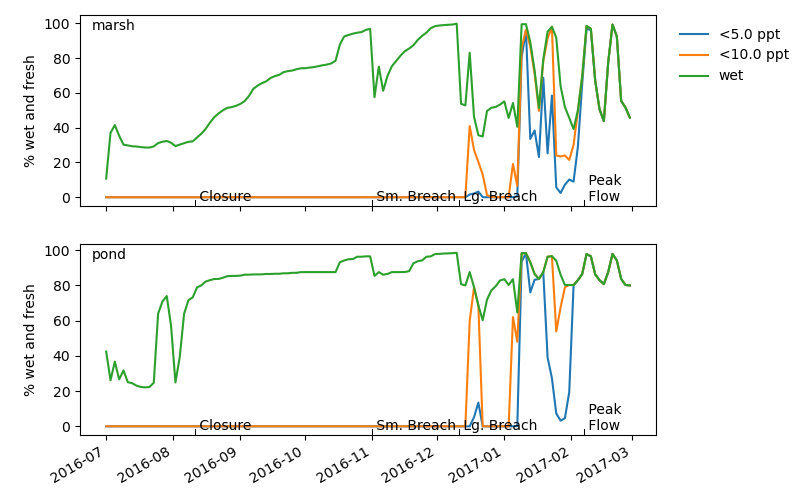

Low


<IPython.core.display.Javascript object>


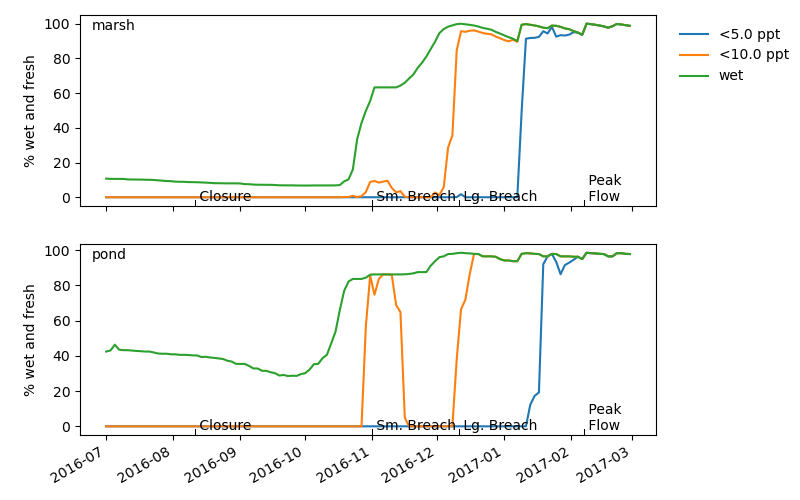

Medium


<IPython.core.display.Javascript object>


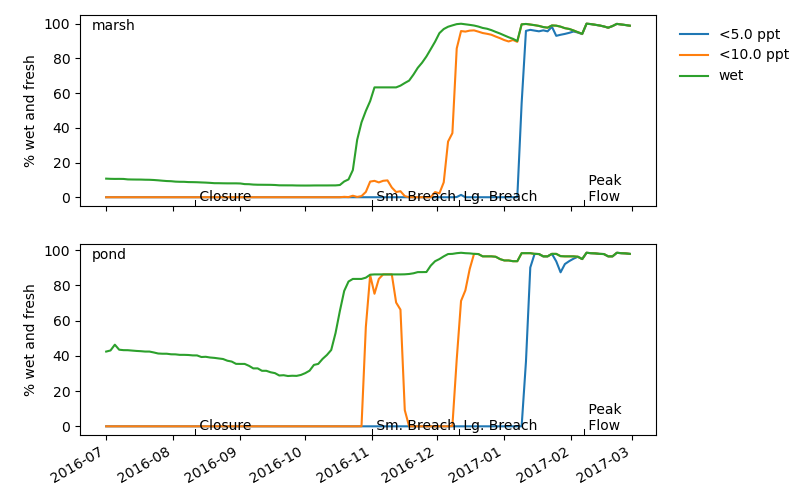

High


<IPython.core.display.Javascript object>


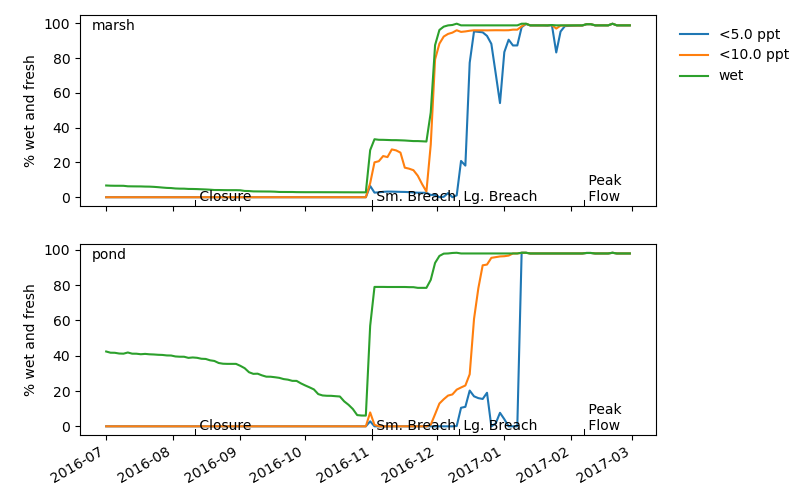

In [43]:
def fig_habitat(result):
    fig,axs=plt.subplots(2,1,sharex=True,figsize=(8,5))

    for region in range(result.dims['region']):
        ax=axs[region]
        ax.text(0.02,0.98,result['region'].values[region],va='top',transform=ax.transAxes)
        for thrsh in range(result.dims['threshold']):
            area=result.habitat.isel(threshold=thrsh,region=region)
            percent=100*area/result.region_area.values[region]
            thresh_val=result.thresholds.values[thrsh]
            if np.isfinite(thresh_val):
                label=f"<{thresh_val} ppt"
            else:
                label='wet'
            ax.plot(result.time, percent, label=label)
    fig.autofmt_xdate()
    for ax in axs:
        ax.set_ylabel('% wet and fresh')
        label_events(ax) # may need tweaking, or hide text on first ax.
    axs[0].legend(loc='upper left',bbox_to_anchor=[1.02,1],frameon=False)
    fig.subplots_adjust(left=0.1,right=0.82,top=0.97,bottom=0.13)
    return fig
    
# Get the polygons for marsh and pond
region_names=['marsh','pond']

for _,rec in fresh_runs.iterrows():
    print(rec['name'])
    result=fresh_wet_area(rec['model'],[5,10,np.inf],region_names=region_names)
    fig=fig_habitat(result)
    fig.savefig(os.path.join(fig_dir,f"habitat-{rec['name']}-{rec['flows']}-{rec['period']}.png"),
                dpi=200)
    
    

In [ ]:
plt.close('all')

Breach
--

In [ ]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
breachruns=all_runs[(all_runs.layers==100) 
                     &(all_runs.slr==0.0) 
                     &(all_runs.period=='2016breach') 
             ].copy()
breachruns['name']=breachruns.scen.map(scen_names)
breachruns

In [ ]:
breachruns['model']=breachruns.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

In [ ]:
# First, just see what the tracer looks like
#mod=runs['model'].values[0]
#mds=mod.map_dataset()

In [ ]:
# Choose a few key moments in time for snapshots
# these runs go from 2016-12-08 to 2016-12-16
def fig_tracer_snapshots(mod,tracer='marsh',
                            times=[np.datetime64("2016-12-09"),
                                   np.datetime64("2016-12-12"),
                                   np.datetime64("2016-12-14")]):
    his=mod.his_dataset()
    mds=mod.map_dataset()

    fig,axs=plt.subplots(1,len(times),figsize=[8.3,3.4])
    fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02,wspace=0.03)

    # one time series 
    ax_t=fig.add_axes([0.03,0.06,0.3,0.14])
    ax_t.plot( his.time, his.waterlevel.sel(stations='nck'))
    ax_t.axis(xmin=his.time.values[0],xmax=his.time.values[-1])
    ax_t.xaxis.set_visible(0)
    ax_t.yaxis.set_visible(0)
    zoom=[551951., 553291., 4124136., 4125020.]

    for t,ax,label in zip(times,axs,"abcdefgh"):
        ax.set_adjustable('datalim')
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)

        tidx=np.searchsorted(mds.time.values,t)
        ax_t.axvline(mds.time.values[tidx],color='0.5',lw=1.5)

        scal=scal_davg(mds,tidx,'mesh2d_'+tracer)
        ccoll=mds.grid.plot_cells(values=scal,cmap='turbo',lw=0.4,edgecolor='face',
                                  ax=ax)
        ccoll.set_clim([0,1])
        ax.axis(zoom)
        ax.text(0.02,0.98,f"({label})",va='top',transform=ax.transAxes)
        ax.axis('off')

    p0=axs[0].get_position()
    p1=axs[1].get_position()
    cax=fig.add_axes([p0.xmax-0.4*p0.width,0.82,p0.width*0.6,0.04])
    plt.colorbar(ccoll,cax=cax,label=f"{tracer} dye tracer",orientation='horizontal')
    return fig

In [ ]:
for _,rec in breachruns.iterrows():
    for tracer in ['marsh','pond']:
        fig=fig_tracer_snapshots(rec['model'],tracer=tracer) 
        fig.savefig(os.path.join(fig_dir,f"breach-snapshots-{tracer}-2016-{rec['name']}.png"),
                    dpi=200)

In [ ]:
def tracer_exposure(mod,tracer):
    mds=mod.map_dataset(chain=False)
    exposure=np.zeros(mds.grid.Ncells(),np.float64)
    dt=(mds.time.values[1]-mds.time.values[0])/np.timedelta64(1,'s')

    for tidx,t in enumerate(utils.progress(mds.time.values)):
        print(mds.time.values[tidx])
        scal=scal_davg(mds,tidx,'mesh2d_'+tracer)
        scal[np.isnan(scal)]=0.0
        exposure+=scal*dt
    return exposure


In [ ]:
# Might have to rerun scen0 -- the marsh release region dips over the
# levee and contaminates the results esp. for exposure.
# Is this issue gone in the scen1 output?
# hmm - worse than that. I think the levee might actually be leaky?
# The DEM goes down to 2.65m here.
from matplotlib import colors

def fig_exposure(mod,tracer):
    exposure=tracer_exposure(mod,tracer)
    mds=mod.map_dataset(chain=False)
    fig,ax=plt.subplots()
    ax.axis('off')
    ax.set_adjustable('datalim')
    scal=exposure/3600. # hours.
    ccoll=mds.grid.plot_cells(values=scal.clip(0.1,8*24),
                              norm=colors.LogNorm(vmin=1,vmax=8*24,clip=True),
                              cmap='turbo',lw=0.5,edgecolor='face',
                              ax=ax)
    plt.colorbar(ccoll,label='Exposure (h)')
    zoom=[551951., 553291., 4124136., 4125020.]
    fig.subplots_adjust(left=0.01,right=0.99,top=0.97,bottom=0.03)
    ax.axis(zoom)
    return fig

In [ ]:
# Integrate exposure to marsh water
for _,rec in breachruns.iterrows():
    for tracer in ['marsh','pond']:
        mod=rec['model']
        fig=fig_exposure(mod,tracer)
        fig.savefig(os.path.join(fig_dir,f"breach-exposure-{tracer}-2016-{rec['name']}.png"),
                    dpi=200)

In [ ]:
plt.close('all')

Bed stress during breach
--

In [ ]:
# Bed stress during breach:

# mean and max bed stress for each of the runs, for flood and ebb
class FigBedStress:
    zoom=[552085, 552647.,4124191, 4125112]
    figsize=None

    def __init__(self,mod,period_sel=slice(None),**kws):
        utils.set_keywords(self,kws)
        mds=mod.map_dataset(chain=False)

        tau=mds['mesh2d_taus'].isel(time=period_sel).values
        tau_max=np.nanmax(tau, axis=0)
        tau_mean=np.mean(tau,axis=0)
        self.fig,self.axs=plt.subplots(1,2,figsize=self.figsize)
        for ax,vals,label in zip(self.axs,
                                 [tau_max,tau_mean],
                                 ['Max. bed stress (Pa)','Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            ccoll=mds.grid.plot_cells(values=vals.clip(0.1),cmap='turbo',ax=ax,norm=colors.LogNorm())
            ccoll.set_clim([0.1,10])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(self.zoom)
        self.fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)
   

In [ ]:
for _,rec in breachruns.iterrows():
    fbs=FigBedStress(rec['model'])
    fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-breach.png"),dpi=200)

In [ ]:
# Compare mean bed stress, per tidal phase, between each scenario
# and the base
class FigBedStressChange(FigBedStress):
    map_dataset_kwargs={}
    def __init__(self,model_base,model_alt,period_sel=slice(None),**kws):
        utils.set_keywords(self,kws)
        ds_base=model_base.map_dataset()
        tau_base=ds_base['mesh2d_taus'].isel(time=period_sel).values
        tau_max_base =np.nanmax(tau_base, axis=0)
        tau_mean_base=np.mean(tau_base,axis=0)

        ds_alt=model_alt.map_dataset(grid=ds_base.grid,**self.map_dataset_kwargs)
        
        # Make sure the grid's are the same
        def check_match():
            cc_base=ds_base.grid.cells_center()
            cc_alt =ds_alt.grid.cells_center()
            valid_grid=np.allclose(cc_base,cc_alt)
            valid_time=np.all(ds_base.time.values==ds_alt.time.values)
            return valid_grid and valid_time
        
        if not check_match():
            print("Grids or times don't look the same. Will try reloading map_dataset")
            # Try reloading with forced grid:
            model_alt._mu=None
            ds_alt=model_alt.map_dataset(grid=ds_base.grid,**self.map_dataset_kwargs)
            assert check_match()
        
        tau_alt=ds_alt['mesh2d_taus'].isel(time=period_sel).values
        tau_max_alt=np.nanmax(tau_alt, axis=0)
        tau_mean_alt=np.mean(tau_alt,axis=0)
        self.fig,self.axs=plt.subplots(1,2)
        for ax,vals,label in zip(self.axs,
                                 [tau_max_alt-tau_max_base,
                                  tau_mean_alt-tau_mean_base],
                                 [r'$\Delta$ Max. bed stress (Pa)',
                                  r'$\Delta$ Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            ccoll=ds_alt.grid.plot_cells(values=vals,cmap='coolwarm',ax=ax,
                                         norm=colors.SymLogNorm(0.1,vmin=-5,vmax=5,base=10),
                                         lw=0.5,edgecolor='face')
            ccoll.set_clim([-2,2])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(self.zoom)
        self.fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)
   

In [ ]:
         
rec_base=breachruns[ breachruns['name']=='Base'].iloc[0,:]

for _,rec in breachruns.iterrows():
    if rec['name']=='Base': continue
    img_fn=os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-breach.png")
    if os.path.exists(img_fn): continue
                        
    fbs=FigBedStressChange(rec_base['model'],rec['model'])
    fbs.fig.savefig(img_fn,dpi=200)

In [ ]:
breachruns.model.values[0].run_start

In [ ]:
breachruns.model.values[0].run_stop

In [ ]:
plt.close('all')

High Flow Bed Stress
--

In [ ]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
runs=all_runs[ 
    (all_runs.layers==100) 
    & (all_runs.period=='2016long')
    & (all_runs.slr==0.0)
].copy()
runs['name']=runs.scen.map(scen_names)
six.moves.reload_module(dfm)
runs['model']=runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

runs

In [ ]:
period_dates=[np.datetime64('2017-01-04'), np.datetime64('2017-02-27') ]

kws=dict(zoom=(551904., 553317., 4123944., 4125157.),
         figsize=(9.1,5))

for _,rec in runs.iterrows():
    mds=rec['model'].map_dataset(chain=True)
    map_times=mds.time.values
    period_sel=(map_times>=period_dates[0]) & (map_times<period_dates[1])
    idxs=np.nonzero(period_sel)[0]
    print(f"Will look at high flow stress from {map_times[idxs[0]]} to {map_times[idxs[-1]]}")
    fbs=FigBedStress(rec['model'],period_sel=period_sel,**kws)
    fbs.fig.savefig(os.path.join(fig_dir,f"bed_stress-{rec['name']}-highflow.png"),dpi=200)


In [ ]:
# Some annoying gymnastics to make sure the runs are on the same grid,
# and same chaining.
rec_base=runs[runs['name']=='Base'].iloc[0,:]
kws=dict(zoom=(551904., 553317., 4123944., 4125157.),
         figsize=(9.1,5))

mds=rec_base['model'].map_dataset(chain=True)
map_times=mds.time.values
period_sel=(map_times>=period_dates[0]) & (map_times<period_dates[1])
idxs=np.nonzero(period_sel)[0]
print(f"Will look at high flow stress from {map_times[idxs[0]]} to {map_times[idxs[-1]]}")
kws['period_sel']=period_sel
kws['map_dataset_kwargs']=dict(chain=True)

for _,rec in runs.iterrows():
    if rec['name']=='Base': continue
    mds=rec['model'].map_dataset(chain=True) 
    
    img_fn=os.path.join(fig_dir,f"bed_stress-diff-{rec['name']}-highflow.png")
    print(f"Checking for image {img_fn}")
    if os.path.exists(img_fn): continue
    fbs=FigBedStressChange(rec_base['model'],rec['model'],**kws)
    fbs.fig.savefig(img_fn,dpi=200)

Salinity time series
--

In [7]:
# time series of top/bottom salinity at some key locations across
# different scenarios.
# Not yet sure how to present this, so stuff it into a netcdf


In [8]:
salt_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['npc','Ped. Bridge'],
                 ['nmp','North Marsh Panne'],
               ]

from stompy import filters

def fig_salinity_bystation_timeseries(runs,station,label,min_depth=0.0):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))
    
    colors=['tab:Blue','tab:Orange','tab:Green','tab:Red']
    #colors=list(Colors)
    alpha=0.12
    t_starts=[]
    t_stops =[]
    
    for color,(_,rec) in zip(colors,runs.iterrows()):
        salt=his_cache(rec['model'],stations=station,variable='salinity')        
        zorder=2
        salt_min=np.nanmin(salt,axis=1)
        salt_max=np.nanmax(salt,axis=1)
        
        if min_depth>0.0:
            eta=his_cache(rec['model'],stations=station,variable='waterlevel')
            z_bed=his_cache(rec['model'],stations=station,variable='bedlevel')
            depth=eta-z_bed
            valid=depth>=min_depth
            salt_min[~valid]=np.nan
            salt_max[~valid]=np.nan
            
        # Data dt is 15 min.
        win=60*4
        salt_min=filters.lowpass_fir(salt_min,win)
        salt_max=filters.lowpass_fir(salt_max,win)
        
        #color=colors.pop(0)
        ax.fill_between(salt.time,
                        salt_min,salt_max,
                        label=rec['name'],color=color,
                        lw=1.2,alpha=alpha,zorder=zorder)
        ax.plot(salt.time,salt_min,lw=0.75,color=color,zorder=3)
        ax.plot(salt.time,salt_max,lw=0.75,color=color,zorder=3)
        t_starts.append(salt.time.values[0])
        t_stops.append(salt.time.values[-1])
        
    ax.legend(loc='upper center',bbox_to_anchor=[0.45,1.12],ncol=len(runs),
              frameon=0)
    label_events(ax)
    # in case some runs are truncated.
    ax.axis(xmin=np.min(t_starts),xmax=np.max(t_stops))
    
    for color,t_stop in zip(colors,t_stops):
        if t_stop<np.max(t_stops):
            ax.axvline(t_stop,color=color,ls=':',lw=0.75)
    
    ax.set_ylabel('Salinity (ppt)')
    ax.text(0.03,0.97,label,transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98,left=0.1,top=0.92, bottom=0.14)
    return fig

In [ ]:
for station,label in salt_stations:
    fig=fig_salinity_bystation_timeseries(runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-2016-stn_{station}.png'),
                dpi=150)

In [ ]:
plt.close('all')

Sea Level Rise
---

Show how the inlet depth is adjusted

In [12]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
sel=( (all_runs.scen==0)
     &(all_runs.layers==100) 
     &(all_runs.period=='2016long')
     &(all_runs.flows=='impaired'))
run_slr =all_runs[ sel&(all_runs.slr==0.61)]['run_dir'].values[0]
run_base=all_runs[ sel&(all_runs.slr==0.00)]['run_dir'].values[0]
print(run_slr)
print(run_base)

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01
data_2016long_3d_asbuilt_impaired_scen0_l100-v027_r01


In [ ]:
model_slr=dfm.DFlowModel.load(run_slr)
model_base=dfm.DFlowModel.load(run_base)

In [ ]:
# This will fail if the grids are ever out of sync
mds_slr=model_slr.map_dataset()
mds_base=model_base.map_dataset(grid=mds_slr.grid)

In [ ]:
# Figure showing how the mouth if adjusted.

zoom_mouth=[551963., 552311., 4124425., 4124912.]
fig,axs=plt.subplots(1,3,figsize=[8.5,3.5])

plt.setp(axs,adjustable='datalim')

z_base=mds_base['mesh2d_flowelem_bl'].values
z_slr = mds_slr['mesh2d_flowelem_bl'].values
delta=z_slr-z_base

coll0=mds_base.grid.plot_cells(values=z_base,ax=axs[0],cmap='turbo')
coll1=mds_slr.grid.plot_cells(values=z_slr,ax=axs[1],cmap='turbo')
coll2=mds_slr.grid.plot_cells(values=delta,cmap='coolwarm',clim=[-0.75,0.75])

for coll in [coll0,coll1]:
    coll.set_clim([0,3.5])
    
for ax in axs:
    ax.axis(zoom_mouth)
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)
    
fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.02)

cax0=fig.add_axes([0.23,0.52,0.02,0.40])
cax2=fig.add_axes([0.885,0.52,0.02,0.40])
plt.colorbar(coll0,cax=cax0,label='m')
plt.colorbar(coll2,cax=cax2,label='m')

for label,ax in zip('abc',axs):
    ax.text(0.05,0.98,f"({label})",transform=ax.transAxes,va='top')
fig.savefig(os.path.join(fig_dir,'slr_mouth_adjustment.png'),dpi=200)

SLR Salinity
--

In [9]:
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
slr_runs=all_runs[ (all_runs.layers==100) 
                  &(all_runs.slr==0.61) # risky...
                  &(all_runs.period=='2016long') 
                 ].copy()
slr_runs['name']=slr_runs.scen.map(scen_names)

slr_runs['model']=slr_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
slr_runs

run_dir  scen  layers   slr  \
4   data_2016long_3d_asbuilt_impaired_scen0_slr0.6...     0     100  0.61   
5   data_2016long_3d_asbuilt_impaired_scen1_slr0.6...     1     100  0.61   
6   datacws_2016long_3d_asbuilt_impaired_scen2_slr...     2     100  0.61   
7   data_2016long_3d_asbuilt_impaired_scen3_slr0.6...     3     100  0.61   
25  data_2016long_3d_asbuilt_unimpaired_scen0_slr0...     0     100  0.61   

      period    status       flows    name  \
4   2016long   running    impaired    Base   
5   2016long  complete    impaired     Low   
6   2016long   running    impaired  Medium   
7   2016long   running    impaired    High   
25  2016long   running  unimpaired    Base   

                                                model  
4   <stompy.model.delft.dflow_model.DFlowModel obj...  
5   <stompy.model.delft.dflow_model.DFlowModel obj...  
6   <stompy.model.delft.dflow_model.DFlowModel obj...  
7   <stompy.model.delft.dflow_model.DFlowModel obj...  
25  <stompy.model.delft.dflow_model.DFlowModel obj...

<IPython.core.display.Javascript object>


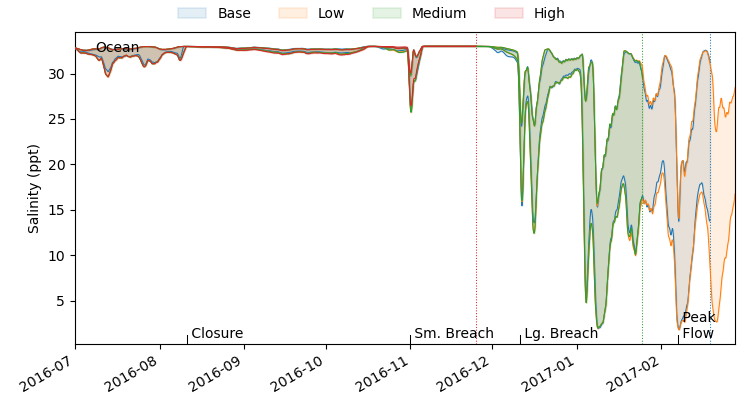

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_salinity.nc cache miss
3 chained datasets
Geometries match?
Geometries match?
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_salinity.nc cache miss
1 chained datasets
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_thalweg_pesc_0000-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


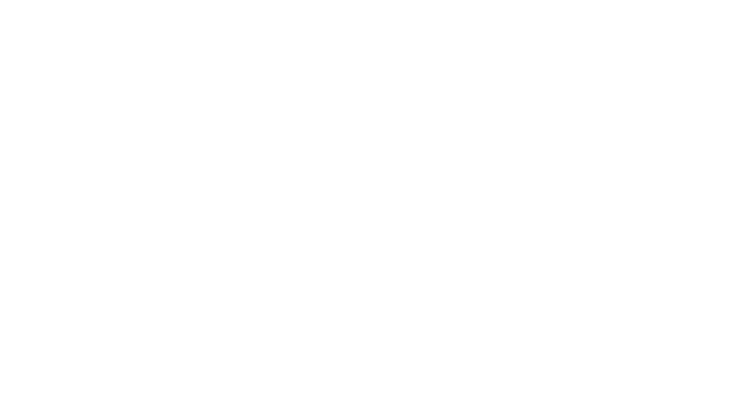

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nck-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


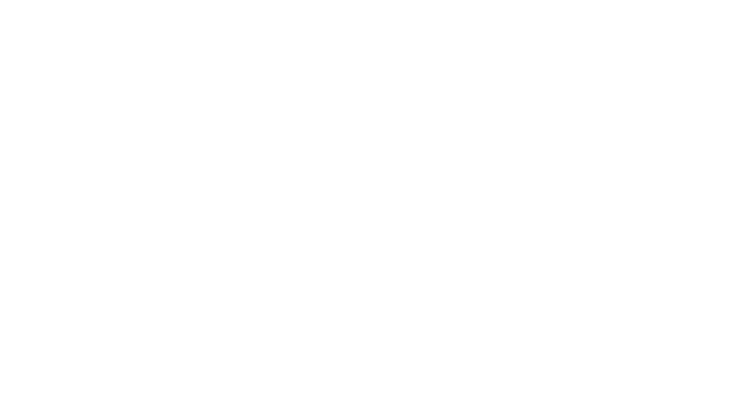

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_pch_up-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


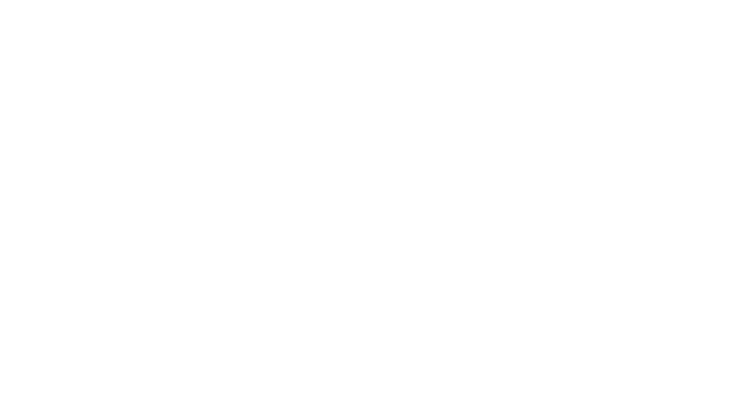

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_npc-var_bedlevel.nc cache miss


<IPython.core.display.Javascript object>


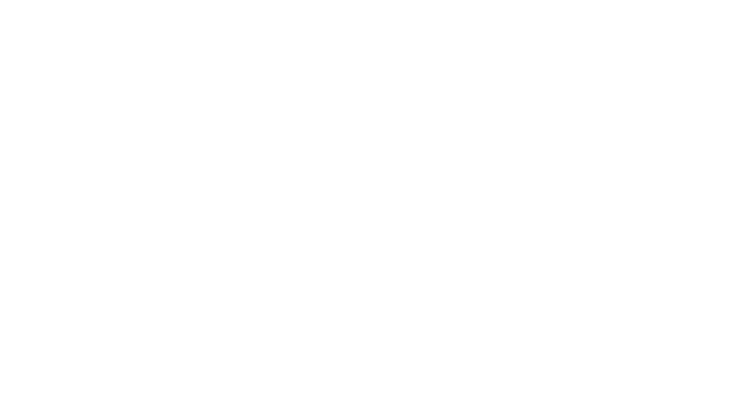

data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen0_slr0.61m_l100-v006_r01/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_bedlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_salinity.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_waterlevel.nc cache miss
data_2016long_3d_asbuilt_impaired_scen3_slr0.61m_l100-v003/DFM_OUTPUT_flowfm/cache/v00-stations_nmp-var_bedlevel.nc cache miss


In [10]:
for station,label in salt_stations:
    fig=fig_salinity_bystation_timeseries(slr_runs,station,label,min_depth=0.025)
    fig.savefig(os.path.join(fig_dir,f'salinity-timeseries-slr-2016-stn_{station}.png'),
                dpi=150)

In [ ]:
plt.close('all')

Impaired, Unimpaired Flows
==

In [29]:
def period_completed(model):
    ds=xr.open_dataset(model.his_output(),decode_cf=True, decode_times=True, decode_coords=False)
    return ds.time.values[0], ds.time.values[-1]
def status(model):
    print(f"{model.run_start} -- {model.run_stop}")
    completed=period_completed(model)
    t_remaining=(model.run_stop - completed[1])/np.timedelta64(1,'D')
    print(f"{t_remaining:.2f} days remaining")
def calc_remaining(model):
    return (model.run_stop - period_completed(model)[1])/np.timedelta64(1,'D')
    
six.moves.reload_module(run_database)
all_runs=run_database.all_runs
flow_runs=all_runs[ (all_runs.layers==100) 
                  &(all_runs.slr.isin([0,0.61]))
                  &(all_runs.period.isin(['2016long','2013']))
                  &(all_runs.scen==0)
                 ].copy()

flow_runs['model']=flow_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))    
flow_runs['remaining']=flow_runs['model'].apply(calc_remaining)

flow_runs

run_dir  scen  layers   slr  \
0   data_2016long_3d_asbuilt_impaired_scen0_l100-v...     0     100  0.00   
4   data_2016long_3d_asbuilt_impaired_scen0_slr0.6...     0     100  0.61   
24  data_2016long_3d_asbuilt_unimpaired_scen0_l100...     0     100  0.00   
25  data_2016long_3d_asbuilt_unimpaired_scen0_slr0...     0     100  0.61   
26      data_2013_3d_asbuilt_impaired_scen0_l100-v000     0     100  0.00   
27    data_2013_3d_asbuilt_unimpaired_scen0_l100-v000     0     100  0.00   
28  data_2013_3d_asbuilt_impaired_scen0_slr0.61m_l...     0     100  0.61   

      period    status       flows  \
0   2016long  complete    impaired   
4   2016long   running    impaired   
24  2016long   running  unimpaired   
25  2016long   running  unimpaired   
26      2013   running    impaired   
27      2013   running  unimpaired   
28      2013   running    impaired   

                                                model   remaining  
0   <stompy.model.delft.dflow_model.DFlowModel obj...    0.000000  
4   <stompy.model.delft.dflow_model.DFlowModel obj...   15.375000  
24  <stompy.model.delft.dflow_model.DFlowModel obj...  183.614583  
25  <stompy.model.delft.dflow_model.DFlowModel obj...  227.854167  
26  <stompy.model.delft.dflow_model.DFlowModel obj...  248.906250  
27  <stompy.model.delft.dflow_model.DFlowModel obj...  279.406250  
28  <stompy.model.delft.dflow_model.DFlowModel obj...  350.229167